<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">TD 2 - IFT 6285</div>

$\textbf{Auteur}$ : Adel Nabli


$\textbf{ID}$: 20121744

# Sujet:

**Sources**: http://www-labs.iro.umontreal.ca/~felipe/IFT6285-Automne2018/frontal.php?page=devoir2.html

Il s'agit d'un problème de classification: deux phrases (l'une en anglais, l'autre en français) sont-elles en relation de traduction? C'est un problème très étudié actuellement avec un impact dans des tâches comme la traduction automatique, l'acquisition de lexiques bilingues ou encore la détection de plagiat.


L'approche que vous aller prendre n'est pas prescrite. Vous pouvez par exemple calculer des features et entraîner un classificateur de manière supervisée. Un exemple d'une telle approche est décrit ici. Vous pouvez utiliser un réseau de neurone pour apprendre une représentation des phrases alimentant un classificateur. Une telle approche (avec code) est disponible ici. Vous pouvez aussi fonctionner de façon heuristique. Un baseline pourrait consister en le calcul d'un embedding par phrase (par exemple la moyenne des embeddings des mots d'une représentation déjà apprise (par exemple avec Word2Vec)) et d'ajuster un seuil au delà duquel le cosine de deux réprésentations indique une relation de traduction.

J'ai produit des exemples d'entraînement (et de test) en générant aléatoirement des paires de phrases à priori négatives. Il s'agit donc d'un problème simplifié dans la mesure ou les exemples négatifs, sont très probablement faciles à classer. Je générerai d'autres jeux de données en cours de projet.

À propos du jeu de test: vous pouvez le découper en dev (pour ajuster des métaparamètres) et en test pour réaliser vos expériences.

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import linalg
from collections import Counter
import re
from tqdm import tqdm
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
import spacy

nlp_en = spacy.load('en')
nlp_fr = spacy.load('fr')

# Loading the data given

* We think that the end point and the '\n' of each line brings artificial similarity between sentences, so we decided to remove them
* On enlève toutes les majuscules (car les embeddings que nous utilisons sont en minuscule)

In [3]:
data_fr = open('train.fr', encoding='utf-8')
data_en = open('train.en', encoding='utf-8')
data_test_en = open('test.en', encoding='utf-8')
data_test_fr = open('test.fr', encoding='utf-8')
Data_fr = []
Data_en = []
Data_test_fr = []
Data_test_en = []

for lines in tqdm(data_fr):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_fr.append(line)

for lines in tqdm(data_en):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_en.append(line)

for lines in tqdm(data_test_fr):

    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_test_fr.append(line)

for lines in tqdm(data_test_en):
    
    line = re.split(" |\.|-|'", lines)
    line.pop(-1)
    
    if line[-1]=='.':
        
        line.pop(-1)
    
    for k in range(len(line)):
        
        line[k] = line[k].lower()
        
    Data_test_en.append(line)

1000000it [00:22, 45108.68it/s]
1000000it [00:20, 48928.10it/s]
200000it [00:04, 44712.11it/s]
200000it [00:03, 57394.17it/s]


In [4]:
words_en = (tokens for sent in Data_en + Data_test_en for tokens in sent)
words_fr = (tokens for sent in Data_fr + Data_test_fr for tokens in sent)
Voc_fr = Counter(words_fr)
Voc_en = Counter(words_en)

In [5]:
print('Taille du vocabulaire français: ', len(Voc_fr), '\n')
print('Taille du vocabulaire anglais: ', len(Voc_en), '\n')

Taille du vocabulaire français:  96929 

Taille du vocabulaire anglais:  68215 



# Loading the embeddings:

**Sources:** 

[1] **A. Joulin, P. Bojanowski, T. Mikolov, H. Jegou, E. Grave**, [*Loss in Translation: Learning Bilingual Word Mapping with a Retrieval Criterion*](https://arxiv.org/abs/1804.07745)

[2] **P. Bojanowski*, E. Grave*, A. Joulin, T. Mikolov**, [*Enriching Word Vectors with Subword Information*](https://arxiv.org/abs/1607.04606)


Nous allons utiliser des embeddings FastText anglais/français qui ont été alignés: les mots sémantiquement proches des deux langues ont une représentation vectorielle proches.

In [6]:
import io

def load_vectors(fname, voc):
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}

    for line in fin:
       
        tokens = line.rstrip().split(' ')
        
        if tokens[0] in voc:
            
            data[tokens[0]] = np.array(tokens[1:]).astype(float)
            
    return data

In [7]:
embeddings_fr = load_vectors('wiki.fr.align.vec', Voc_fr)
embeddings_en = load_vectors('wiki.en.align.vec', Voc_en)

In [8]:
print('Nombre de mots du vocabulaire français sans vecteur: ', -len(embeddings_fr) + len(Voc_fr), '\n')
print('Nombre de mots du vocabulaire anglais sans vecteur: ', -len(embeddings_en) + len(Voc_en))

Nombre de mots du vocabulaire français sans vecteur:  17132 

Nombre de mots du vocabulaire anglais sans vecteur:  8367


**Note**:

On se rend compte que tous les mots n'ont pas d'embeddings !
En effet, toutes les valeures numériques n'ont pas de vecteur associé. Cependant, il y a une dissymétrie claire entre le français et l'anglais: en inspectant, on se rend compte que les mots anglais non vectorisés sont presques exclusivement des valeures numériques et des noms propres, alors qu'en français certaines conjugaisons "exotiques" apparaissent dans les mots non vectorisés. On essait donc de diminuer le nombre de mots sans vecteurs en lemmatisant les mots non "pris en charge" et en essayant de voir si on peut leur attribuer un vecteur.

In [9]:
Mapping_words_fr = dict()

for words in tqdm(Voc_fr):
    
    Mapping_words_fr[words] = None
    
    if words in embeddings_fr:
        
        # The Mapping links a word to itself if the word has already a vector
        
        Mapping_words_fr[words] = words
        
    if words not in embeddings_fr:
        
        # If the word doesn't have a vector
        
        if re.search('[0-9]', words) is None:
            
            # if the word does not contain any decimal
            
            doc = nlp_fr(words)
            lemma = None
            
            for tokens in doc:
                
                # We find the lemma of the word
                
                lemma = tokens.lemma_
            
            if lemma in embeddings_fr:
                
                # if the lemma is known, we map the word to its lemma
                
                Mapping_words_fr[words] = lemma

100%|██████████████████████████████████████████████████████████████████████████| 96929/96929 [01:18<00:00, 1236.17it/s]


In [10]:
Mapping_words_en = dict()

for words in tqdm(Voc_en):
    
    Mapping_words_en[words] = None
    
    if words in embeddings_en:
        
        # The Mapping links a word to itself if the word has already a vector
        
        Mapping_words_en[words] = words
        
    if words not in embeddings_en:
        
        # If the word doesn't have a vector
        
        if re.search('[0-9]', words) is None:
            
            # if the word does not contain any decimal
            
            doc = nlp_en(words)
            lemma = None
            
            for tokens in doc:
                
                # We find the lemma of the word
                
                lemma = tokens.lemma_
            
            if lemma in embeddings_en:
                
                # if the lemma is known, we map the word to its lemma
                
                Mapping_words_en[words] = lemma

100%|██████████████████████████████████████████████████████████████████████████| 68215/68215 [00:27<00:00, 2476.56it/s]


In [11]:
cpt_fr = 0
cpt_en = 0

for words, mappings in Mapping_words_fr.items():
    
    if mappings is not None:
        
        cpt_fr +=1

for words, mappings in Mapping_words_en.items():
    
    if mappings is not None:
        
        cpt_en +=1

print('Nombre de mots du vocabulaire français sans vecteur après opération: ', -len(embeddings_fr) + cpt_fr, '\n')
print('Nombre de mots du vocabulaire anglais sans vecteur après opération: ', -len(embeddings_en) + cpt_en)

Nombre de mots du vocabulaire français sans vecteur après opération:  2208 

Nombre de mots du vocabulaire anglais sans vecteur après opération:  154


**Note**:

On a donc réussi à grandement diminuer le nombre de mots sans représentations vectorielles grâce à cette astuce.

# Présentation des différentes features utilisées:

## 1) Computing Discrete Fréchet Distance

Calculer la distance de fréchet est en général non trivial. Le cas des courbes polygonales est cependant solvable en $O(pq\log(pq))$. L'algorithme décrit originellement étant assez complexe à implémenter, nous nous sommes rabattus sur une approximation souvent utilisée, qui a l'avantage d'être plus rapide à calculer: la *discrete fréchet distance*

**Source:** 

[3] **T.Eiter, H.Mannila** [Computing Discrete Fréchet Distance](http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf)

![title](Algo_frechet_distance.png)

Nous implémentons en python l'algorithme présenté ci-dessus:

In [12]:
from scipy.spatial import distance as distance_

In [13]:
def distance(u,v):
    
    return(np.linalg.norm(u-v))
    #return(distance_.cosine(u,v))

In [14]:
def c(i, j, P, Q, ca):
    
    if ca[i,j] > -1:
        
        return(ca[i,j])
    
    elif i == 0 and j == 0:
        
        ca[i,j] = distance(P[0], Q[0])
    
    elif i > 0 and j == 0:
        
        ca[i,j] = np.max(np.array([c(i-1, 0, P, Q, ca), distance(P[i], Q[0])]))
    
    elif i == 0 and j > 0:
        
        ca[i,j] = np.max(np.array([c(0, j-1, P, Q, ca), distance(P[0], Q[j])]))
    
    elif i > 0 and j > 0:
        
        ca[i,j] = np.max(np.array([
            np.min(np.array([c(i-1, j, P, Q, ca), c(i-1, j-1, P, Q, ca), c(i, j-1, P, Q, ca)])),
            distance(P[i], Q[j])]))
    
    else:
        
        ca[i,j] = math.inf
    
    return(ca[i,j])

In [15]:
def compute_frechet_distance(P, Q):
    
    p = len(P)
    q = len(Q)
    ca = -1*np.ones((p,q))
    
    return(c(p-1, q-1, P, Q, ca))

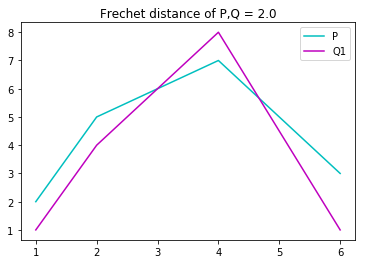

In [16]:
# Exemple 1

P = np.array([[1,2], [2,5], [4,7], [6,3]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

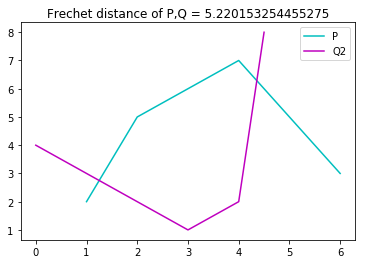

In [17]:
# Exemple 2

P = np.array([[1,2], [2,5], [4,7], [6,3]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

On remarque bien que plus les courbes polygonales sont "semblables", plus la distance est faible....mais attention, la distance est **très sensible** aux pics/bruit !


On peut le remarquer avec les exemples suivants:

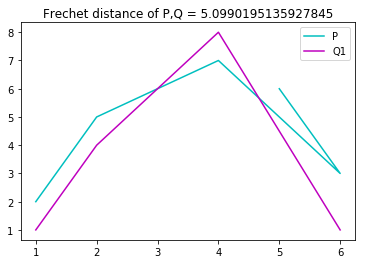

In [18]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

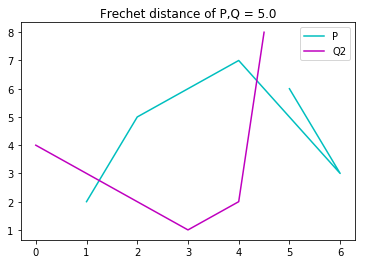

In [19]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

frechet_dist = compute_frechet_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Frechet distance of P,Q = %s' %str(frechet_dist))
plt.show()

En rajoutant à la fin un "pic", la courbe Q2 est maintenant plus proche de P au sens de Frechet !

## 2) Hausdorff distance between two paths

Nous allons utiliser l'implémentation de $\texttt{scipy}$ de la distance de hausdorff. Cette implémentation est cependant celle de la *directed hausdorff*, à savoir que la pseudo distance est asymétrique: $d(P,Q) \neq d(Q,P)$. Ainsi, cela nous oblige à prendre le maximum des deux distances comme distance finale.

In [20]:
from scipy.spatial.distance import directed_hausdorff

In [21]:
def compute_hausdorff_distance(P,Q):
    
    return(max(directed_hausdorff(P, Q)[0], directed_hausdorff(Q, P)[0]))

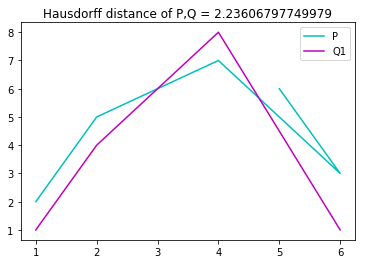

In [22]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

hausdorff_dist = compute_hausdorff_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Hausdorff distance of P,Q = %s' %str(hausdorff_dist))
plt.show()

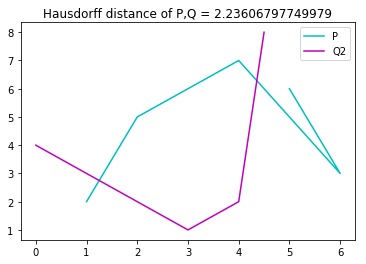

In [23]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

hausdorff_dist = compute_hausdorff_distance(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Hausdorff distance of P,Q = %s' %str(hausdorff_dist))
plt.show()

Il semblerait donc qu'au sens de Hausdorff, ces deux courbes soient espacées de la même manière

## 3)  Analyse procustéenne

Nous allons encore une fois utiliser la librairie $\texttt{scipy}$ pour cela.

**Attention**:
Calculer la distance entre 2 séquences avec cette méthode requière des séquences de *même longeur*. Nous allons donc ajouter des vecteurs de 0 à la fin de la séquence la plus petite.

In [24]:
from scipy.spatial import procrustes

In [25]:
def compute_procrustes_disparity(P,Q):
    
    p = len(P)
    q = len(Q)
    dim = np.shape(P)[1]
 
    if p > q:
        
        zeros = np.zeros((p-q, dim))
        Q = np.concatenate((Q,zeros), axis=0)
    
    elif q > p:
        
        zeros = np.zeros((q-p, dim))
        P = np.concatenate((P,zeros), axis=0)
    
    mtx1, mtx2, disparity = procrustes(P, Q)
    
    return(disparity)

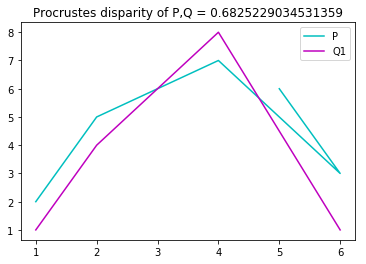

In [26]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

procrustes_disp = compute_procrustes_disparity(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Procrustes disparity of P,Q = %s' %str(procrustes_disp))
plt.show()

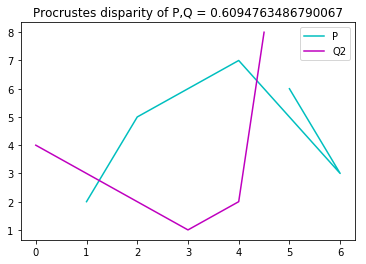

In [27]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

procrustes_disp = compute_procrustes_disparity(P,Q)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Procrustes disparity of P,Q = %s' %str(procrustes_disp))
plt.show()

Avec cette mesure, Q2 est plus éloigné de P que Q1 l'est

## 4) Une mesure "maison" de la similarité entre 2 phrases

Nous allons cette fois utiliser une mesure créée de toute pièce pour comparer la similarité entre deux phrases anglaises/françaises.

* On part de cette slide du cours:

![title](proba_alignement.png)

Ainsi, cela nous dit que l'on peut s'attendre que les mots en relation de traductions entre une phrase anglaise et française qui sont une traduction l'une de l'autre sont situés plus ou moins à la même position relative dans leurs phrases respectives (pour une phrase anglais $e = e_1 \; e_2 .... e_t ... e_E$ en traduction avec une phrase française $f = f_1....f_t...f_F$, on peut s'attendre que la traduction du mot $e_t$ soit proche de $f_t$ dans la phrase française).

Ainsi, si on a 2 phrases en relation de traduction, on peut s'attendre qu'en regardant dans l'entourage du vecteur $f_t$, on trouve un vecteur dont le cosine est faible avec le vecteur $e_t$.

On construit alors la mesure suivante:

$home\_made\_distance = \dfrac{1}{2 \min(E,F)} \Big(\sum_{t \in [\![1, E]\!]} \min_{k \in entourage(t')} \big( d_{cosine}(f_k, e_t) \big) + \sum_{t \in [\![1, F]\!]} \min_{k \in entourage(t'')} \big( d_{cosine}(e_k, f_t) \big)\Big)$

Avec: $t' = \Big \lfloor \dfrac{t}{E}F \Big \rfloor$, $t'' = \Big \lfloor \dfrac{t}{F}E \Big \rfloor$ et $entourage(t)$ étant l'ensemble des mots qui sont dans la phrase entre les positions $t-n_{entourage}$ et $t+n_{entourage}$.

La normalisation par $\min(E,F)$ étant là pour pénaliser un gros grand écart de longeur entre les deux phrases.

Cela se traduit par l'algorithme suivant:

_________________
**ALGORITHME :**

* **Demande** de $n_{entourage}$
* **Initialisation**: $\Sigma_{cosine} =0$
* **Pour tout mot** $e_t$ dans $e$ (avec $t \in [\![1, E]\!])$, **faire**:

$\hspace{2cm}$ - **Calculer** $t' = \Big \lfloor \dfrac{t}{E}F \Big \rfloor$

$\hspace{2cm}$ - **Chercher** le mot dans l'entourage de $f_{t'}$ qui a le cosine le plus faible avec $e_t$ (on défini $cosine^t$ ce cosine minimal)

$\hspace{2cm}$ - $\Sigma_{cosine}$ += $cosine^t$

* **Pour tout mot** $f_t$ dans $f$ (avec $t \in [\![1, F]\!])$, **faire**

$\hspace{2cm}$ - **Calculer** $t'' = \Big \lfloor \dfrac{t}{F}E \Big \rfloor$

$\hspace{2cm}$ - **Chercher** le mot dans l'entourage de $e_{t''}$ qui a le cosine le plus faible avec $f_t$ (on défini $cosine^t$ ce cosine minimal)

$\hspace{2cm}$ - $\Sigma_{cosine}$ += $cosine^t$

* **Retourner** $\dfrac{\Sigma_{cosine}}{2\min(E,F)}$

_______


In [28]:
def home_made_measure(P,Q, n_neighborhood):
    
    sum_cosine = 0
    E = len(P)
    F = len(Q)
    
    for t in range(E):
        
        t_ = int((t/(E-1))*(F-1))
        
        borne_inf = t_ - n_neighborhood
        borne_inf = (borne_inf > 0)*borne_inf
        borne_sup = t_ + n_neighborhood
        borne_sup = borne_sup*(borne_sup < F) + F*(borne_sup >= F)
        
        min_cosine = math.inf
        
        for i in range(borne_inf, borne_sup):
            
            dist = distance_.cosine(P[t], Q[i])
            
            if dist < min_cosine:
                
                min_cosine = dist
                
        sum_cosine += min_cosine
    
    for t in range(F):
        
        t_ = int((t/(F-1))*(E-1))
        
        borne_inf = t_ - n_neighborhood
        borne_inf = (borne_inf > 0)*borne_inf
        borne_sup = t_ + n_neighborhood
        borne_sup = borne_sup*(borne_sup < E) + E*(borne_sup >= E)
        
        min_cosine = math.inf
        
        for i in range(borne_inf, borne_sup):
            
            dist = distance_.cosine(Q[t], P[i])
            
            if dist < min_cosine:
                
                min_cosine = dist
                
        sum_cosine += min_cosine
        
    sum_cosine = sum_cosine / (2*min(E,F))
    
    return(sum_cosine)

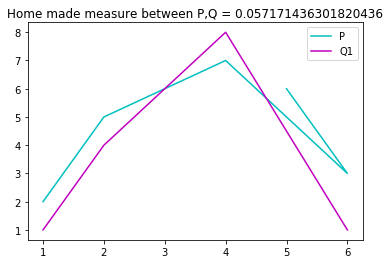

In [29]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

dist_home_made = home_made_measure(P,Q, 1)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Home made measure between P,Q = %s' %str(dist_home_made))
plt.show()

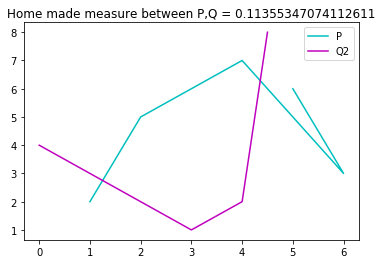

In [30]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

dist_home_made = home_made_measure(P,Q, 1)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Home made measure between P,Q = %s' %str(dist_home_made))
plt.show()

Avec cette distance maison, on arrive à dire que Q2 est plus éloigné de P que l'est Q1

## 5) Stacc inspired measure

Nous allons utiliser une sorte de variante de la mesure de Stacc en tirant partie de nos embeddings. Au lieu de créer les ensembles de "mots traduits", nous allons juste definir une boule pour la distance cosine, centrée sur le mot que l'on considère et dont le rayon $r$ est un hyperparamètre. Ainsi, on considèrera l'intersection de ces boules avec les embeddings de la phrase dans l'autre langue.

Dans la méthode originelle, on normalise le cardinal de l'intersection avec celui de l'union car on "crée" des traductions. Dans notre méthode, vu que l'on ne crée pas ces traductions (on regarde juste dans un voisinage), on choisira de normaliser plutôt par le nombre théorique maximal qu'il pourrait apparaître dans les sommes de cardinal (à savoir $E \times F$, atteint dans le cas de 2 phrases identiques constituées de répétition du même mot).

Finalement, notre mesure est définie par:

$RevisitedStacc = \dfrac{1}{2 E \times F} \Big (\sum_{t \in [\![1,E]\!]} |\mathcal{B}_{cosine}(e_t, r) \cap \{f_{t'} \}_{t' \in [\![1,F]\!]} | + \sum_{t' \in [\![1,F]\!]} |\mathcal{B}_{cosine}(f_{t'}, r) \cap \{e_{t} \}_{t \in [\![1,E]\!]} |\Big)$

In [31]:
def stacc_revisited(P,Q, r):
    
    card1 = 0
    
    for words in P:
        
        for mots in Q:
            
            card1 += (distance_.cosine(words, mots) < r)*1
    
    card2 = 0
    
    for mots in Q:
        
        for words in P:
            
            card2 += (distance_.cosine(words, mots) < r)*1
    
    return((card1 + card2)/(2*len(P)*len(Q)))

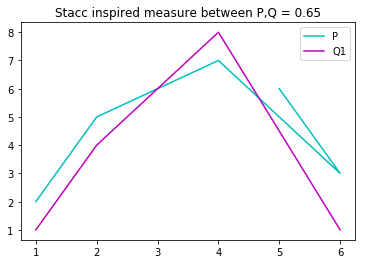

In [32]:
# Exemple 1, bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[1,1], [2,4], [4,8], [6,1]])

stacc_inspired = stacc_revisited(P,Q, 0.07)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q1')
plt.legend()
plt.title('Stacc inspired measure between P,Q = %s' %str(stacc_inspired))
plt.show()

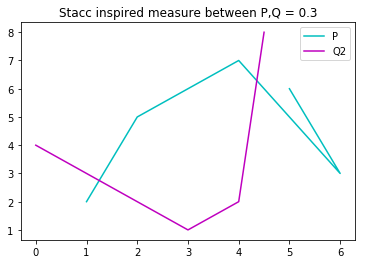

In [33]:
# Exemple 2 bis

P = np.array([[1,2], [2,5], [4,7], [6,3], [5,6]])
Q = np.array([[0,4], [3,1], [4,2], [4.5,8]])

stacc_inspired = stacc_revisited(P,Q, 0.07)

plt.plot(P[:,0], P[:,1], color='c', label='P')
plt.plot(Q[:,0], Q[:,1], color='m', label='Q2')
plt.legend()
plt.title('Stacc inspired measure between P,Q = %s' %str(stacc_inspired))
plt.show()

Cela semble encore donner de bons résultats

## 6) Distance cosine des moyennes des phrases

Comme proposé dans le sujet, nous allons ajouter cette feature simple.

In [34]:
def compute_cosine_mean_embeddings(P,Q):
    
    E = np.mean(P, axis=0)
    F = np.mean(Q, axis=0)
    return(distance_.cosine(E,F))

# Main algorithm predicting whether the sentences are linked or not

On va ainsi:

* Représenter chaque phrase de notre dataset comme une suite d'embeddings, et ceux pour les deux langues
* Calculer pour ces deux suites les 6 features présentées
* Voir à la fin si cela nous permet de bien séparer nos données en deux ensembles distincts (en entraînant un classifieur par exemple)

**Calcul des features pour chaque paires de phrases**:

In [35]:
def compute_the_features(Data_en, Data_fr,
                         Mapping_words_en, Mapping_words_fr,
                         embeddings_en, embeddings_fr,
                         n_neighborhood, r_stacc):
    
    """Take the test sets and compute for each pairs of sentences the values of the 5 features"""
    
    n_sentences = len(Data_en)
    matrix_of_features = []
    
    for k in tqdm(range(n_sentences)):
        
        line_en = Data_en[k]
        line_fr = Data_fr[k]
        P_k = []
        Q_k = []
        features_k = [0]*6
        
        for words in line_en:
            
            word_2 = Mapping_words_en[words]
            
            if word_2 is not None:
                
                P_k.append(embeddings_en[word_2])
        
        P_k = np.array(P_k)
        
        for mots in line_fr:
            
            mot_2 = Mapping_words_fr[mots]
            
            if mot_2 is not None:
                
                Q_k.append(embeddings_fr[mot_2])
        
        Q_k = np.array(Q_k)
        
        features_k[0] = compute_frechet_distance(P_k, Q_k)
        features_k[1] = compute_hausdorff_distance(P_k,Q_k)
        features_k[2] = compute_procrustes_disparity(P_k,Q_k)
        features_k[3] = home_made_measure(P_k,Q_k, n_neighborhood)
        features_k[4] = stacc_revisited(P_k,Q_k, r_stacc)
        features_k[5] = compute_cosine_mean_embeddings(P_k,Q_k)
        
        matrix_of_features.append(features_k)
    
    return(matrix_of_features)

**Choix d'un bon r_stacc**:

In [36]:
distance_.cosine(embeddings_fr['la'], embeddings_en['the'])

0.5560150889111046

In [37]:
distance_.cosine(embeddings_fr['fenêtre'], embeddings_en['king'])

1.1140877963513336

Un bon r_stacc semble donc être 0.7

In [38]:
matrix_of_features = compute_the_features(Data_test_en[0:5000] + Data_test_en[100000:105000], Data_test_fr[0:5000] + Data_test_fr[100000:105000],
                                          Mapping_words_en, Mapping_words_fr,
                                          embeddings_en, embeddings_fr,
                                          3, 0.7)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:27<00:00,  8.87it/s]


**Extraction du vecteur réponse y:**

In [39]:
data_y = open('test.y', encoding='utf-8')
y = []

for answers in data_y:
    
    y.append(int(answers))

In [40]:
y_extracted = y[0:5000] + y[100000:105000]

**Visualisation des données après standardisation:**

In [41]:
X = StandardScaler().fit_transform(matrix_of_features)

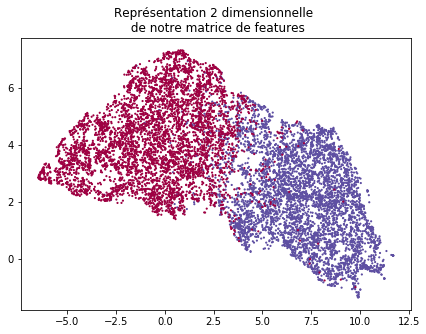

In [185]:
plt.figure(figsize=(7,5))
embedding_seuclidean = umap.UMAP(random_state=42, metric='manhattan').fit_transform(X)
plt.scatter(embedding_seuclidean[:, 0], embedding_seuclidean[:, 1], c=y_extracted, cmap='Spectral', s=1.3)
plt.title('Représentation 2 dimensionnelle \n de notre matrice de features')
plt.show()

**Commentaire**: Les features que nous avons calculées semblent donc bien séparer les données ! On attend donc de bons résultats en entraînant un classifieur.

# Results and discussions:

**Entraînement d'un classifieur et résultats:**

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y_extracted, test_size=.50, random_state=42)

In [183]:
clf = RandomForestClassifier(n_estimators=450, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
y_pred  = clf.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
print ('Accuracy with a Random Forest: ',acc)
pd.DataFrame(clf.feature_importances_, index=['Discrete Fréchet', 'Hausdorff', 'Procrustes', 'Home Made', 'Stacc inspired', 'Cosine of means'], columns=['Relative Importance of features'])

Accuracy with a Random Forest:  0.975


,Relative Importance of features
Discrete Fréchet,0.114075
Hausdorff,0.293744
Procrustes,0.035640
Home Made,0.432739
Stacc inspired,0.065276
Cosine of means,0.058526


**De l'innutilité de présenter beaucoup de données**:

In [186]:
def predict_on_data(X, y, size_of_test):
    
    accuracy = []
    nb_train_examples = []
    
    for sizes in size_of_test:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sizes, random_state=41)
        clf = RandomForestClassifier(n_estimators=450, n_jobs=-1, random_state=0)
        clf.fit(X_train, y_train)
        y_pred  = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        nb_train_examples.append(int((1-sizes)*len(X)))

    plt.figure(figsize=(6,4))
    plt.plot(nb_train_examples, accuracy, color='m', label='Final accuracy = %s' %str(accuracy[-1]))
    plt.title("Evolution de l'accuracy en fonction \n de la taille du train set")
    plt.xlabel("Nombre de données d'entraînement (échelle log)")
    plt.xscale('log')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

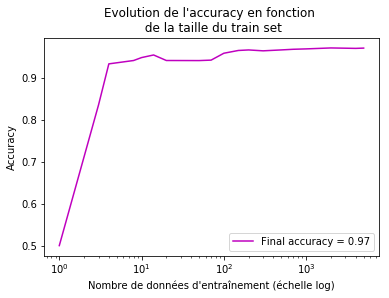

In [187]:
sizes = [0.9998, 0.9996, 0.9995, 0.9992, 0.999, 0.9985, 0.998, 0.995, 0.993, 0.99, 0.985, 0.98, 0.97, 0.95, 0.93, 0.9, 0.8, 0.6, 0.5]
predict_on_data(X, y_extracted, sizes)

**Observations**:

* On obtient une accuracy de 97% en n'utilisant que 1000 phrases à l'entraînement
* On remarque que la "meilleur" features est la distance que l'on a créé (40% d'importance). Ensuite la distance de Hausdorff (30%) et la distance de Fréchet (15%) sont celles de plus grande importance.

**Accuracy obtained if we use only one feature**:

In [176]:
def accuracy_each_feature_alone(X, y):
    
    d = np.shape(np.array(X))[1]
    accuracies = []
    
    for j in range(d):
        
        X_train, X_test, y_train, y_test = train_test_split(np.reshape(X[:,j], (len(X),1)), y, test_size=0.5, random_state=42)
        clf = RandomForestClassifier(n_estimators=450, n_jobs=-1, random_state=0)
        clf.fit(X_train, y_train)
        y_pred  = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    fig, ax = plt.subplots()   
    ax.barh(['Discrete Fréchet', 'Hausdorff', 'Procrustes', 'Home Made', 'Stacc inspired', 'Cosine of means'], accuracies, color='c')
    plt.xlabel('Accuracy')
    plt.title('Accuracies using only one feature')
    
    for i, v in enumerate(accuracies):
        
        ax.text(v-0.3, i-0.07, str(v), color='k')
    
    plt.show()

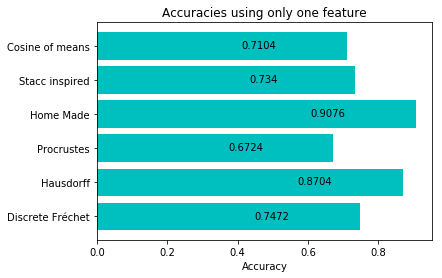

In [177]:
accuracy_each_feature_alone(X, y_extracted)

**Inspection des mauvaises prédictions**:

In [138]:
def inspect_bad_predictions(y_pred, y_test, Data_en, Data_fr, size_of_test, random_seed):
    
    Data_EN = Data_en[0:5000] + Data_en[100000:105000]
    Data_FR = Data_fr[0:5000] + Data_fr[100000:105000]
    
    e1, Data_test_EN, e2, e3 = train_test_split(Data_EN, y_extracted, test_size=size_of_test, random_state=random_seed)
    f1, Data_test_FR, f2, f3 = train_test_split(Data_FR, y_extracted, test_size=size_of_test, random_state=random_seed)
    
    indices = np.where(y_pred - y_test != 0)[0]
    
    for ids in indices:
        
        sentence_fr = str()
        sentence_en = str()
        
        for words in Data_test_EN[ids]:
            
            sentence_en += ' ' + str(words)
        
        for mots in Data_test_FR[ids]:
            
            sentence_fr += ' ' + str(mots)
        
        print('\n \n', sentence_fr, '\n', sentence_en, '\n', 'prédit:', y_pred[ids], '\n réel:', y_test[ids])

In [145]:
inspect_bad_predictions(y_pred, y_test, Data_test_en, Data_test_fr, 0.5, 42)


 
  premièrement , il est affirmé que 90 % des mesures d  efficacité énergétique peuvent être financées par les pays en développement eux mêmes   
  however , we must also take into account the current health problems which are cardiovascular diseases , diabetes , obesity and cancer   
 prédit: 1 
 réel: 0

 
  identification et enregistrement des animaux de l  espèce porcine ( version codifiée ) ( 
  identification and registration of pigs ( 
 prédit: 0 
 réel: 1

 
  ordre du jour de la prochaine séance : voir procès verbal 
  agenda for next sitting : see minutes 
 prédit: 0 
 réel: 1

 
  les chiffres , en revanche , reflètent une toute autre image   
  figures , however , show otherwise   
 prédit: 0 
 réel: 1

 
  nous ferions mieux de savoir quelle partie des activités de l  agence comprendra les tâches relatives aux soins de santé imposées par les institutions   
  there is much work still to be done but allow me to state and to emphasise that the importance of the social part

  il est essentiel d  introduire de nouvelles normes et de nouveaux principes de sécurité que toutes les parties impliquées et conjointement responsables en ce qui concerne l  extraction du pétrole brut devront suivre   
  that being so , it seems to me that a certain number of guarantees have been obtained on the purpose of the data , on the use to which the data may be put and on the storage of the data   
 prédit: 1 
 réel: 0

 
  il suffit pour s  en convaincre d  examiner le paragraphe 18 du projet de conclusions du conseil pour trouver certains des mots équivoques qui ont été insérés   
  look at the draft council conclusions   paragraph 18   and see some of the weasel words that have been inserted   
 prédit: 0 
 réel: 1

 
  nous répétons qu  il n  y a rien de nouveau , que ce soit dans les rapports " les femmes et l  industrie " , " les femmes et la santé " ou " les femmes dans les zones rurales "   
  we repeat that it is nothing new , whether in the reports on   women and in

  we are ready to work constructively with the european parliament and the council in order to find good solutions for europe and , possibly , for the rest of the world   
 prédit: 1 
 réel: 0

 
  je ne pense pas que ce soit le cas   
  i take a different view   
 prédit: 0 
 réel: 1

 
  les raisons de cette absence sont d  ordre procédural   
  that is the decision , then   
 prédit: 1 
 réel: 0

 
  certes , le heading 4 est trop peu financé   
  heading 4 is of course underfunded   
 prédit: 0 
 réel: 1

 
  la création d  un nouveau poste " dépenses exceptionnelles en cas de crise " doit également être soulignée , même si ce que l  on doit entendre par " crise " n  est pas clair   
  the creation of a new heading   exceptional crisis expenditure   also needs to be highlighted , although it is not clear what should be understood by   crisis     
 prédit: 0 
 réel: 1

 
  certains pays , parmi les plus importants dans l  union européenne , n  ont pas de comité d  éthique et ce , pr